In [1]:
import sys
sys.path.insert(0, '../../Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import math

D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1ty

In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
RandomSeed = 1233
np.random.seed(RandomSeed)
tf.set_random_seed(RandomSeed)

In [3]:
class PtPINN:
    def __init__(self, x, t, u, lb, ub, lb1, ub1,layers,weights_values,biases_values):
        
        X = np.concatenate([x, t], 1)

        self.X = X
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        
        self.u = u
        self.hsadasjd=0 
        self.lb = lb
        self.ub = ub
        
        self.lb1 = lb1
        self.ub1 = ub1
        

        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers) 
        
        self.weights_values = weights_values        
        self.biases_values = biases_values          
        
        # Calculate the values and convert them to float64
        value_float64 = 1.0 / math.tanh(0.5 * 5)
        self.b = tf.constant(value_float64, dtype=tf.float64)
        
        value_float64=  1.0/(math.cosh(5*0.5)-1)       
        
        self.a = tf.constant(value_float64, dtype=tf.float64)     

        
        
        self.hh=[]
        self.hh1=[]
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))    

        self.x_f_tf = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float64, shape=[None, self.t.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.t_b_tf = tf.placeholder(tf.float64, shape=[None, self.t.shape[1]])
        self.x_ub_tf = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.x_tf = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float64, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float64, shape=[None, self.u.shape[1]])

        self.u_pred, _, _ = self.net_CE(self.x_tf, self.t_tf)
        self.u_lb_pred, _, _ = self.net_CE(self.x_lb_tf, self.t_b_tf)
        self.u_ub_pred, _, _ = self.net_CE(self.x_ub_tf, self.t_b_tf)

        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)
        

        
        self.lossS = tf.reduce_mean(tf.square(self.u_tf - self.u_pred))
                                              
        self.lossB = tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred))
                                             
        self.lossfu = tf.reduce_mean(tf.square(self.f_pred))
        

        self.optimizer_Adam = tf.train.AdamOptimizer()

        
        self.loss  =  self.lossS + 20* self.lossB + self.lossfu
        

        
        
        
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)      
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
    
        init = tf.global_variables_initializer()
        self.sess.run(init)
        self.save = tf.train.Saver(max_to_keep=1)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = tf.Variable(tf.zeros([layers[l], layers[l+1]], dtype=tf.float64), dtype=tf.float64)
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float64), dtype=tf.float64)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float64))
    
    
    
    def custom_function(self,t):
        
        condition2 = tf.less_equal(t, 0.5)
        condition3 = tf.less_equal(t, 0.6)
        b=10*(t-0.5)
        
        return tf.where(condition2, tf.zeros_like(t), tf.where(condition3, -2*b**3+3*b**2,tf.zeros_like(t)+1))
    
    
    def neural_net(self, x,t, weights, biases,weights_values,biases_values):
        
        num_layers = len(weights) + 1
        X = tf.concat([x,t],1)
        H = 2.0*(X - self.lb1)/(self.ub1 - self.lb1) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            W1 = weights_values[l]
            b1 = biases_values[l]   
            
            H0 = tf.add(tf.matmul(H, W), b)
            H1 = tf.add(tf.matmul(H, W1), b1)
            
            B = self.custom_function(t)   
            H0 = H0*B              
            
            H  = tf.add(H0,H1)
            H =  tf.tanh(H)
        
        W = weights[-1]
        b = biases[-1]
        W1 = weights_values[-1]
        b1 = biases_values[-1]  
        
        H0 = tf.add(tf.matmul(H, W), b)
        
        B = self.custom_function(t)   
        H0 = H0*B            
        
        H1 = tf.add(tf.matmul(H, W1), b1) 
        H  = tf.add(H0,H1)      
        Y = H
        
        return Y
    
    def net_CE(self, x, t):
        X = tf.concat([x,t],1)
        u = self.neural_net(x,t, self.weights, self.biases,self.weights_values, self.biases_values)
        u_x = tf.gradients(u, x)[0]
        u_t = tf.gradients(u, t)[0]
        return u, u_x, u_t

    def net_f(self, x, t):
        u, u_x, u_t = self.net_CE(x, t)
        f_u = u_t + 40*u_x 
        return f_u
    
 
    
    
    
    def callback(self, loss, a,b,lossfu, lossS, lossB):
        sss=self.hsadasjd
        if sss%1000==0:
            print('Loss: %.6e, Lossfu: %.3e, LossS: %.3e, LossB: %.3e ' % (loss, lossfu, lossS, lossB))
        sss=sss+1
        self.hsadasjd=sss 
        self.hh.append(a)      
        self.hh1.append(b) 
    def train(self, nIter, Nf, Nn, Nb):

        X_train = self.lb + (self.ub-self.lb)*lhs(2, Nf)
        self.xtrain_f = X_train[:,0:1]
        self.ttrain_f = X_train[:,1:2] 
        
        X_lb_train = self.lb + [0,self.ub[1]-self.lb[1]]*lhs(2, Nb)
        self.xtrain_lb = X_lb_train[:,0:1]
        self.ttrain_b = X_lb_train[:,1:2]
        
        X_ub_train = [self.ub[0],0] + [0,self.ub[1]-self.lb[1]]*lhs(2, Nb)
        self.xtrain_ub = X_ub_train[:,0:1]
        
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u,
                   self.x_lb_tf: self.xtrain_lb, self.t_b_tf: self.ttrain_b, 
                   self.x_ub_tf: self.xtrain_ub, 
                   self.x_f_tf: self.xtrain_f, self.t_f_tf: self.ttrain_f}

        start_time = time.time()
        
        for it in range(nIter):
                loss_value = self.sess.run(self.loss, tf_dict)
                lossfu = self.sess.run(self.lossfu, tf_dict)
                lossS = self.sess.run(self.lossS, tf_dict)
                lossB = self.sess.run(self.lossB, tf_dict)
                self.sess.run(self.train_op_Adam, tf_dict)
                ab= self.sess.run(self.a)
                self.hh.append(ab)       
                abc= self.sess.run(self.b)
                self.hh1.append(abc)                 
            
                if it % 1000 == 0:
                    print('It: %d, Loss: %.6e, Lossfu: %.3e, LossS: %.3e, LossB: %.3e' % (it, loss_value, lossfu, lossS, lossB))
            
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, method = 'L-BFGS-B', options = {'maxiter': 50000,'maxfun': 50000,'maxcor': 50,'maxls': 50,'ftol' : 1.0 * np.finfo(float).eps})                                                                                                         
        self.optimizer.minimize(self.sess, feed_dict = tf_dict, fetches = [self.loss,self.a,self.b,  self.lossfu, self.lossS, self.lossB], loss_callback = self.callback)        
                                    
    
    def predict(self, x, t):
        
        tf_dict = {self.x_tf: x, self.t_tf: t}
        u_star = self.sess.run(self.u_pred, tf_dict)
        
        return u_star

    def saver(self, string):
        self.save.save(self.sess, 'ckpt/'+string)

    def sssss(self):
        return self.hh,  self.hh1  
        
    def restore(self):
        model_file = tf.train.latest_checkpoint('ckpt/')
        self.save.restore(self.sess, model_file)

In [4]:
import pickle

In [5]:
with open('weights.pkl', 'rb') as f:
    weights_values = pickle.load(f)

In [6]:
with open('weights1.pkl', 'rb') as f:
    biases_values = pickle.load(f)

In [7]:
if __name__ == "__main__": 
    # Doman bounds
    lb = np.array([0, 0])
    ub = np.array([2*np.pi, 1.0])
    
    lb1 = np.array([0, 0])
    ub1 = np.array([2*np.pi, 0.5])    
    
    Nb = 100
    N0 = 400
    
    layers = [2,100,100,100,100,1]
    
    def Exact_Solution(x, t):
        u = np.sin(x-40*t)
        return u

    N0 = 1200
    x=np.linspace(0,2*np.pi,N0).flatten()[:,None]  
    X0 =x
    T0 = np.full((N0,1), lb1[1])
    u0 = Exact_Solution(X0,T0)

In [8]:
    model = PtPINN(X0, T0, u0, lb, ub, lb1, ub1, layers,weights_values,biases_values)                          
    model.train(5000, 10000, 1200, 1200)             

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
It: 0, Loss: 4.571614e+00, Lossfu: 1.306e-03, LossS: 6.677e-08, LossB: 2.285e-01
It: 1000, Loss: 4.299759e-01, Lossfu: 1.636e-01, LossS: 6.677e-08, LossB: 1.332e-02
It: 2000, Loss: 2.691419e-02, Lossfu: 1.952e-02, LossS: 6.677e-08, LossB: 3.698e-04
It: 3000, Loss: 3.230493e-02, Lossfu: 2.454e-02, LossS: 6.677e-08, LossB: 3.882e-04
It: 4000, Loss: 1.133095e-02, Lossfu: 8.678e-03, LossS: 6.677e-08, LossB: 1.326e-04

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Loss: 1.043706e-02, Lossfu: 8.241e-03, LossS: 6.677e-08, LossB: 1.098e-04 
Loss: 1.655641e-03, Lossfu: 1.334e-03, LossS: 6.677e-08, LossB: 1.609e-05 
Loss: 1.016163e-03, Lossfu: 8.244e-04, LossS: 6.677e-08, LossB: 9.582e-06 
Lo

In [9]:
    x=np.linspace(0,2*np.pi,1200).flatten()[:,None]   
    t=np.linspace(0,0.5,1200).flatten()[:,None]  
    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_pred1=model.predict(X_star[:,0:1],X_star[:,1:2])
    u_star1 = Exact_Solution(X_star[:,0:1],X_star[:,1:2])
    u_star=u_star1.flatten()[:,None]  
    u_pred=u_pred1.flatten()[:,None] 
    error_u1 = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_u2 = np.linalg.norm(u_star-u_pred,1)/len(u_star)
    error_u3 = np.linalg.norm(u_star-u_pred,np.inf)
    print('二范数Error u: %e' % (error_u1))
    print('平均绝对Error u: %e' % (error_u2))
    print('无穷范数Error u: %e' % (error_u3))

二范数Error u: 3.979398e-04
平均绝对Error u: 2.394529e-04
无穷范数Error u: 7.269167e-04


In [10]:
    x=np.linspace(0,2*np.pi,1200).flatten()[:,None]   
    t=np.linspace(0,1,1200).flatten()[:,None]  
    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_pred1=model.predict(X_star[:,0:1],X_star[:,1:2])
    u_star1 = Exact_Solution(X_star[:,0:1],X_star[:,1:2])
    u_star=u_star1.flatten()[:,None]  
    u_pred=u_pred1.flatten()[:,None] 
    error_u1 = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_u2 = np.linalg.norm(u_star-u_pred,1)/len(u_star)
    error_u3 = np.linalg.norm(u_star-u_pred,np.inf)
    print('二范数Error u: %e' % (error_u1))
    print('平均绝对Error u: %e' % (error_u2))
    print('无穷范数Error u: %e' % (error_u3))
    u_star=u_star1.flatten()[:,None] 
    Exact =u_star.reshape(1200,1200).T   

二范数Error u: 2.164305e-03
平均绝对Error u: 7.930505e-04
无穷范数Error u: 8.190357e-03


In [11]:
    scipy.io.savemat("duiliuwednn.mat", {'u': u_pred})

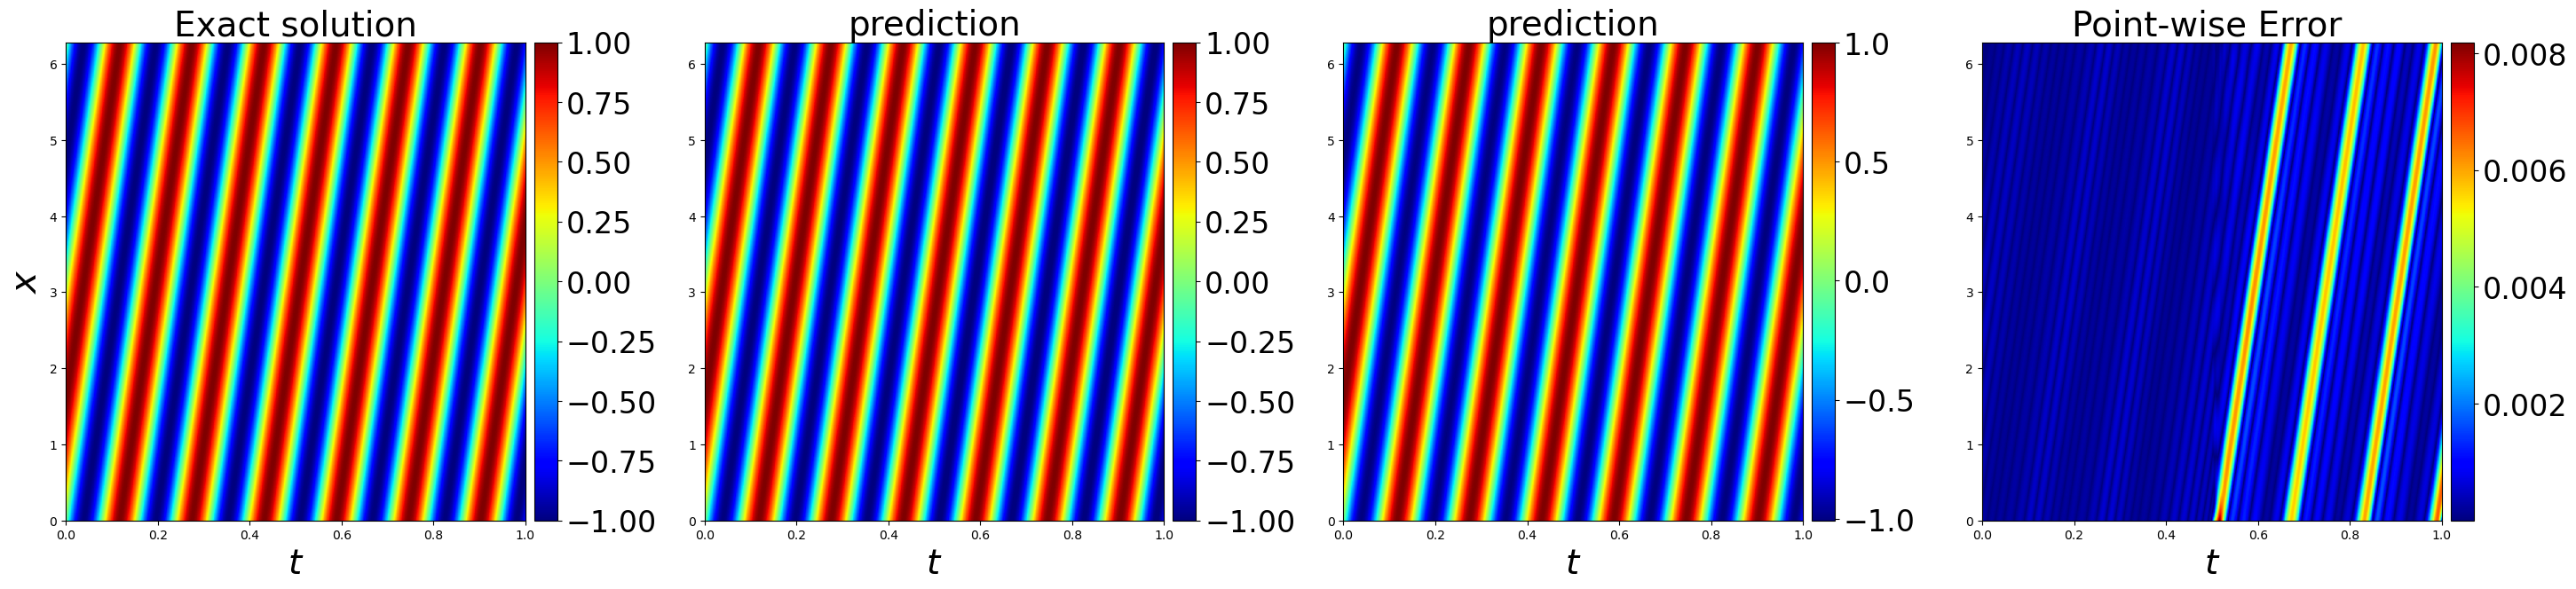

In [12]:
    lb = np.array([0, 0])
    ub = np.array([2*np.pi, 1])

    Exact_h=Exact 

    U_preds=u_pred.reshape(1200,1200).T    

    fig, axs = plt.subplots(1, 4, figsize=(35, 7))
    fig.subplots_adjust(wspace=0.3)  # 调整子图之间的水平间距

    # 第一个子图
    ax1 = axs[2]    
    h = ax1.imshow(U_preds, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax1.set_title(r'prediction', fontsize=28)
    ax1.set_xlabel('$t$', fontsize=28)
    #左边的色差图
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(h, cax=cax)  

    cbar.ax.tick_params(labelsize=24)   
    
    
    # 第一个子图
    ax1 = axs[1]    
    h = ax1.imshow(U_preds, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto',vmin=Exact.min(),vmax=Exact.max())
    ax1.set_title(r'prediction', fontsize=28)
    ax1.set_xlabel('$t$', fontsize=28)
    #左边的色差图
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(h, cax=cax)  

    cbar.ax.tick_params(labelsize=24)      
    
    
    
    ax2 = axs[0]    
    h = ax2.imshow(Exact, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax2.set_title('Exact solution', fontsize=28)
    ax2.set_xlabel('$t$', fontsize=28)
    ax2.set_ylabel('$x$', fontsize=30)
    #左边的色差图
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(h, cax=cax)  

    cbar.ax.tick_params(labelsize=24)       
    
    ax3 = axs[3]    
    h = ax3.imshow(np.abs(Exact-U_preds), interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax3.set_title(r'Point-wise Error ', fontsize=28)
    ax3.set_xlabel('$t$', fontsize=28)
    #左边的色差图
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(h, cax=cax)  

    cbar.ax.tick_params(labelsize=24)     
    
    #plt.savefig('Waterasdes.jpg', dpi=500, bbox_inches='tight') # 解决图片不清晰，不完整的问题
    #plt.savefig('0_15_exact_solution_and_point_wise_error_by_mmpinn_and_standard.pdf', bbox_inches='tight') 
    plt.show() 